# Test for ABC with updating prior

## Simulation and ABC Method

## Assessment of ABC results

In [61]:
import pandas as pd
from ggplot import *
import numpy as np
import os

### Combine results into one dataframe

In [47]:
def create_PosteriorCharacteristics_df(observed_file_name, PosteriorCharacteristics_file_name, obs, chrom):
    observed_df = pd.read_csv(observed_file_name, sep='\t')
    observed_df.drop([col for col in observed_df.columns if 'CGI' in col], axis=1, inplace=True)
    PosteriorCharacteristics_df = pd.read_csv(PosteriorCharacteristics_file_name, sep='\t')
    
    PosteriorCharacteristics_observed_df = pd.concat([observed_df, PosteriorCharacteristics_df], axis=1)
    PosteriorCharacteristics_observed_df['obs'] = str(obs)
    PosteriorCharacteristics_observed_df['chr'] = chrom
    PosteriorCharacteristics_observed_df.drop('dataSet', axis=1, inplace=True)
    return PosteriorCharacteristics_observed_df


def combine_obs_chrom_PosteriorCharacteristics(results_path, obs_list, chrom_list):
    combined_PosteriorCharacteristics_observed_df = pd.DataFrame()
    for obs in obs_list:
        for chrom in chrom_list:
            observed_file_name = '{}/obs{}/chr{}/ABC/results_param_observed.txt'.format(results_path, obs, chrom)
            PosteriorCharacteristics_file_name = '{}/obs{}/chr{}/ABC/ABC_update_estimate_10pls_100ret_model0_MarginalPosteriorCharacteristics.txt'.format(results_path, obs, chrom)
            PosteriorCharacteristics_observed_df = create_PosteriorCharacteristics_df(observed_file_name, PosteriorCharacteristics_file_name, obs, chrom)

            combined_PosteriorCharacteristics_observed_df = pd.concat([combined_PosteriorCharacteristics_observed_df, PosteriorCharacteristics_observed_df])

    return combined_PosteriorCharacteristics_observed_df

In [66]:
results_path = '/vol_c/ABC_update'
combined_PosteriorCharacteristics_observed_name = '{}/ABC_update_estimate_10pls_100ret_model0_MarginalPosteriorCharacteristics_combined.txt'.format(results_path)
obs_list = list(range(1, 101))
chrom_list = list(range(1, 11))

if os.path.isfile(combined_PosteriorCharacteristics_observed_name):
    combined_PosteriorCharacteristics_observed_df = pd.read_csv(combined_PosteriorCharacteristics_observed_name, sep='\t')
else:
    combined_PosteriorCharacteristics_observed_df = combine_obs_chrom_PosteriorCharacteristics(results_path, obs_list, chrom_list)
    combined_PosteriorCharacteristics_observed_df.to_csv(combined_PosteriorCharacteristics_observed_name, sep='\t', index=False)
parameters = list(combined_PosteriorCharacteristics_observed_df)[0:7]

In [67]:
combined_PosteriorCharacteristics_observed_df.head()

A             B             C           AN         AB_t  \
0  50616.323806  3.134282e+06  3.035583e+06  3012.142973  3271.717532   
1  50616.323806  3.134282e+06  3.035583e+06  3012.142973  3271.717532   
2  50616.323806  3.134282e+06  3.035583e+06  3012.142973  3271.717532   
3  50616.323806  3.134282e+06  3.035583e+06  3012.142973  3271.717532   
4  50616.323806  3.134282e+06  3.035583e+06  3012.142973  3271.717532   

          AC_t         AN_t   A_mode   A_mean  A_median ...   \
0  1998.433504  1481.963069  60907.6  57157.6   59181.3 ...    
1  1998.433504  1481.963069  61816.6  61122.5   62427.9 ...    
2  1998.433504  1481.963069  89997.4  75189.0   77290.8 ...    
3  1998.433504  1481.963069  85745.9  72687.7   74628.7 ...    
4  1998.433504  1481.963069  78620.4  69933.6   72841.7 ...    

   AN_t_HDI50_lower  AN_t_HDI50_upper  AN_t_HDI90_lower  AN_t_HDI90_upper  \
0           848.989           1352.53           517.679           1756.14   
1          1068.810           1349.08           863.838           1550.37   
2          1200.180           1413.70          1039.530           1566.12   
3          1178.440           1348.63          1054.950           1468.58   
4          1285.960           1465.67          1158.030           1590.11   

   AN_t_HDI95_lower  AN_t_HDI95_upper  AN_t_HDI99_lower  AN_t_HDI99_upper  \
0           405.281           1884.33           186.370           2123.00   
1           805.273           1623.64           688.144           1767.84   
2           990.729           1620.74           893.121           1724.54   
3          1012.750           1504.55           931.787           1576.54   
4          1111.500           1623.25          1026.670           1685.83   

   obs  chr  
0    1    1  
1    1    2  
2    1    3  
3    1    4  
4    1    5  

[5 rows x 142 columns]

### Functions to calculate things

In [50]:
def calc_estimate_dist(param, combined_PosteriorCharacteristics_observed_df):
    estimate = '{}_mode'.format(param)
    estimate_dist_name = '{}_estimate_dist'.format(param)
    combined_PosteriorCharacteristics_observed_df[estimate_dist_name] = (combined_PosteriorCharacteristics_observed_df[estimate] - combined_PosteriorCharacteristics_observed_df[param])**2
    return combined_PosteriorCharacteristics_observed_df


def calc_HPDI_dist(param, combined_PosteriorCharacteristics_observed_df):
    HDI95_upper_name = '{}_HDI95_upper'.format(param)
    HDI95_lower_name = '{}_HDI95_lower'.format(param)
    HPDI_dist_name = '{}_HPDI_dist'.format(param)
    HDI95_upper = combined_PosteriorCharacteristics_observed_df[HDI95_upper_name]
    HDI95_lower = combined_PosteriorCharacteristics_observed_df[HDI95_lower_name]
    true = combined_PosteriorCharacteristics_observed_df[param]
    
    combined_PosteriorCharacteristics_observed_df[HPDI_dist_name] = np.where((true < HDI95_lower) & (true > HDI95_upper), ((true - HDI95_lower)**2 + (true - HDI95_upper)**2)*(-1), (true - HDI95_lower)**2 + (true - HDI95_upper)**2)    
    return combined_PosteriorCharacteristics_observed_df

### Functions to plot things

In [51]:
def boxplot_estimate_dist(param, combined_PosteriorCharacteristics_observed_df, y_axis_name):
    plot = ggplot(aes(x = 'chr', y = y_axis_name), data = combined_PosteriorCharacteristics_observed_df) + \
        geom_boxplot() + \
        theme_bw()
    return plot


def lineplot_estimate_dist(param, combined_PosteriorCharacteristics_observed_df, y_axis_name):
    plot = ggplot(aes(x = 'chr', y = y_axis_name, colour='obs'), data = combined_PosteriorCharacteristics_observed_df) + \
        geom_point() + \
        geom_line() + \
        theme_bw()
    return plot

### Box plot of the squared difference of the parameter estimate from the observed value for each chromosome
Ideally, each successive chromosome should reduce the squared difference from the observed value

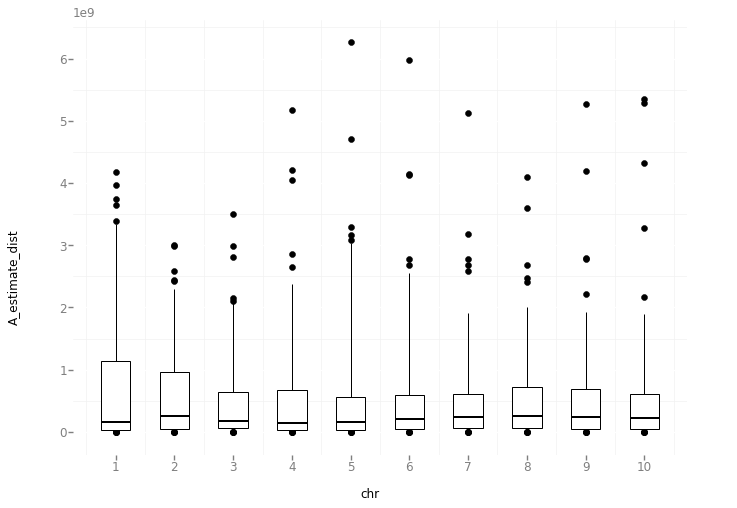

<ggplot: (8784492449663)>


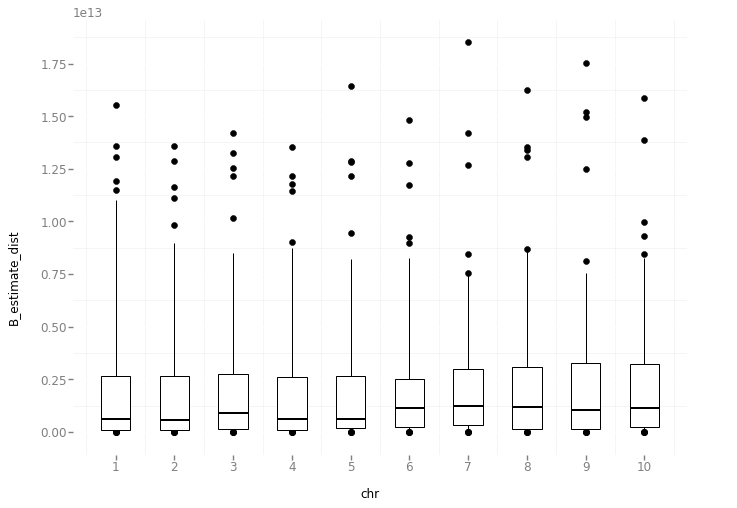

<ggplot: (-9223363252366683960)>


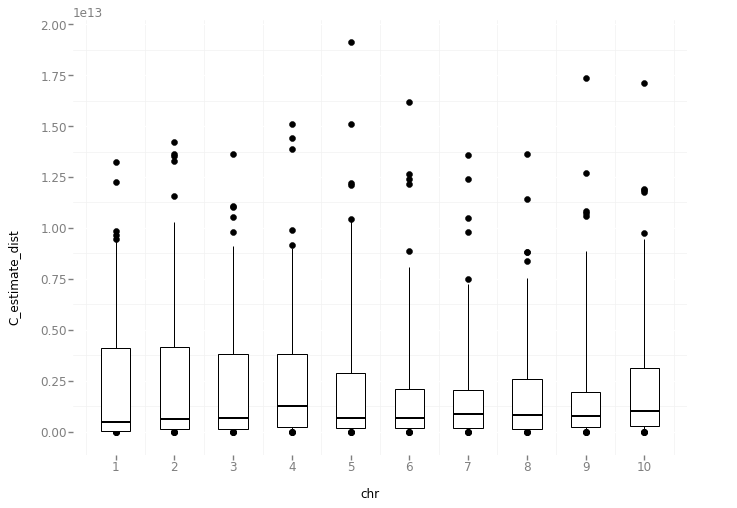

<ggplot: (-9223363252308288943)>


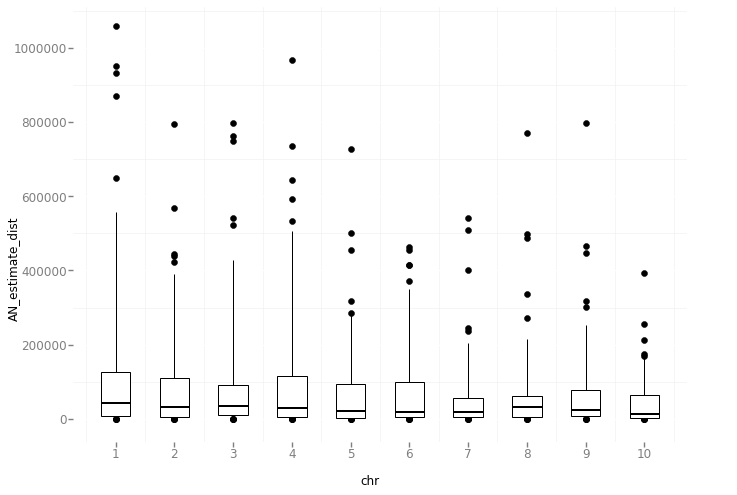

<ggplot: (-9223363252362326924)>


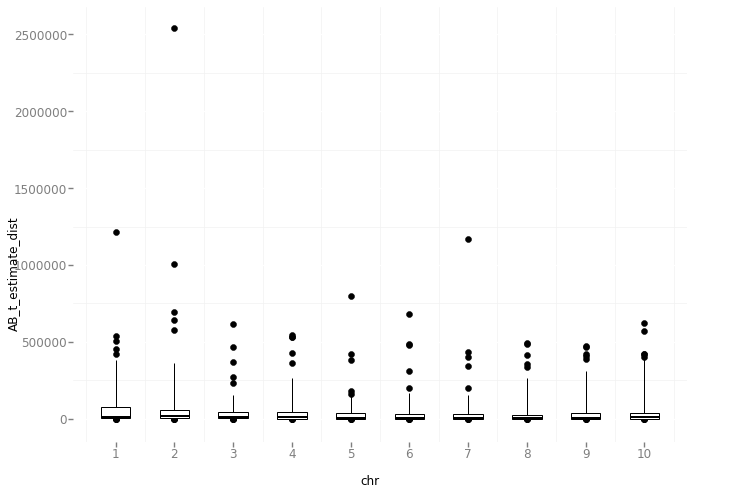

<ggplot: (8784492422797)>


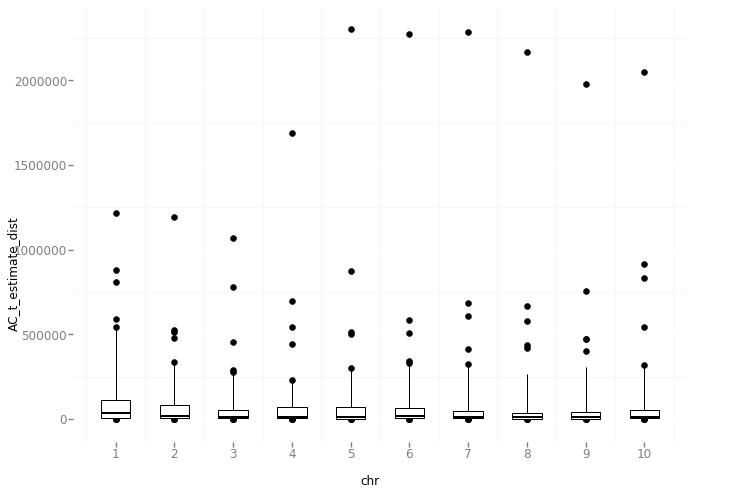

<ggplot: (8784493016296)>


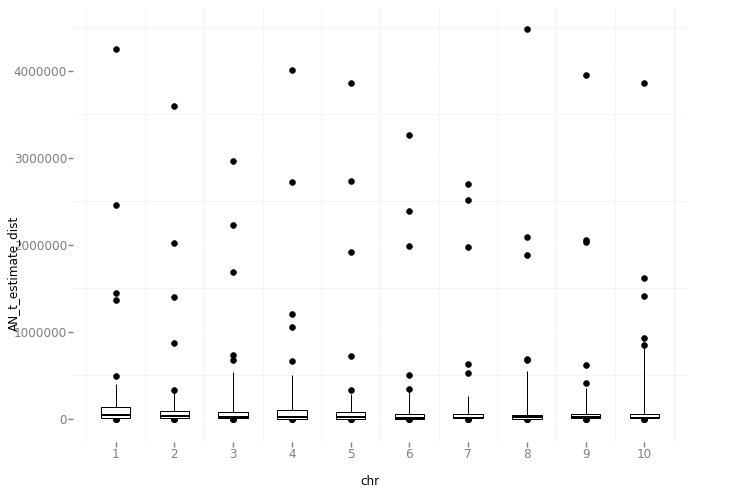

<ggplot: (-9223363252366704489)>


In [52]:
for param in parameters:
    combined_PosteriorCharacteristics_observed_df = calc_estimate_dist(param, combined_PosteriorCharacteristics_observed_df)
    estimate_dist_name = '{}_estimate_dist'.format(param)
    plot = boxplot_estimate_dist(param, combined_PosteriorCharacteristics_observed_df, estimate_dist_name)
    print(plot)

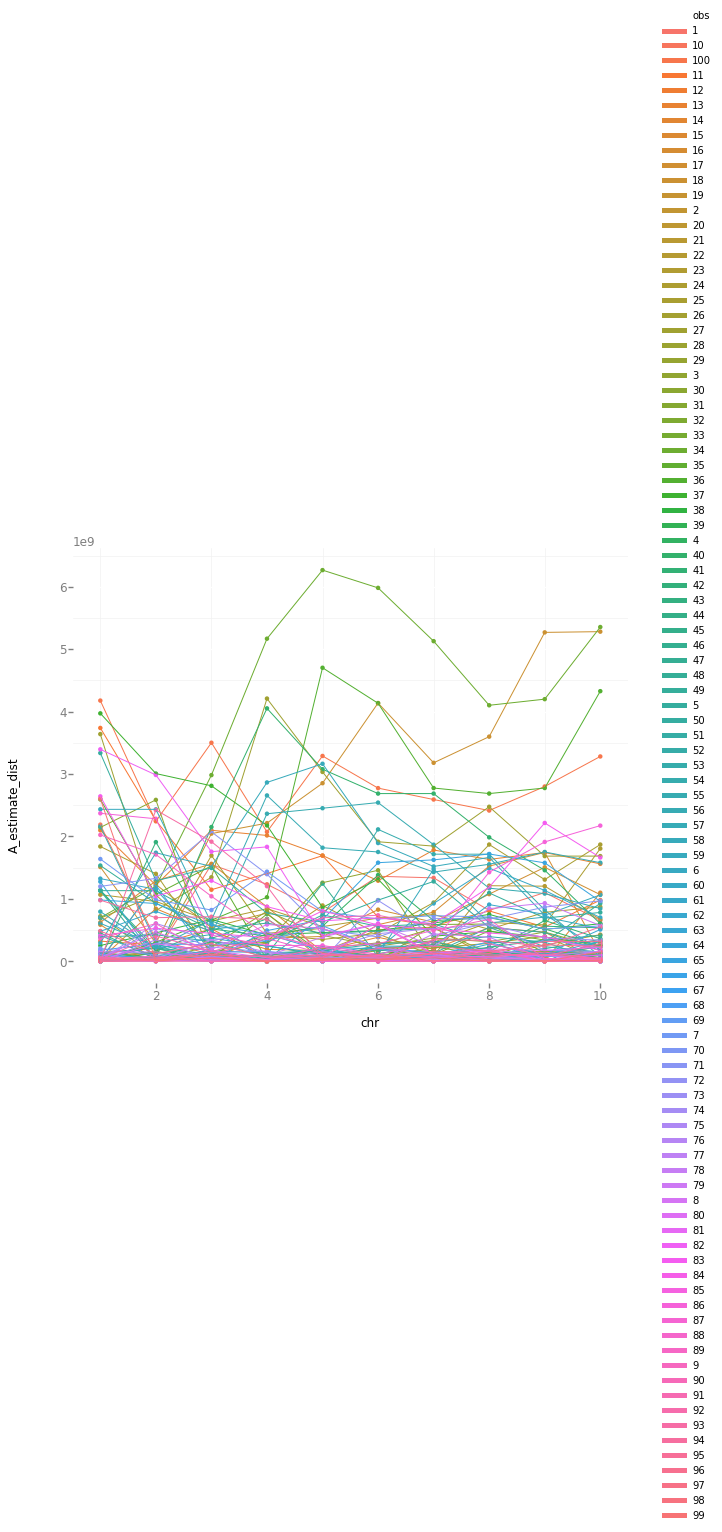

<ggplot: (8784492449768)>


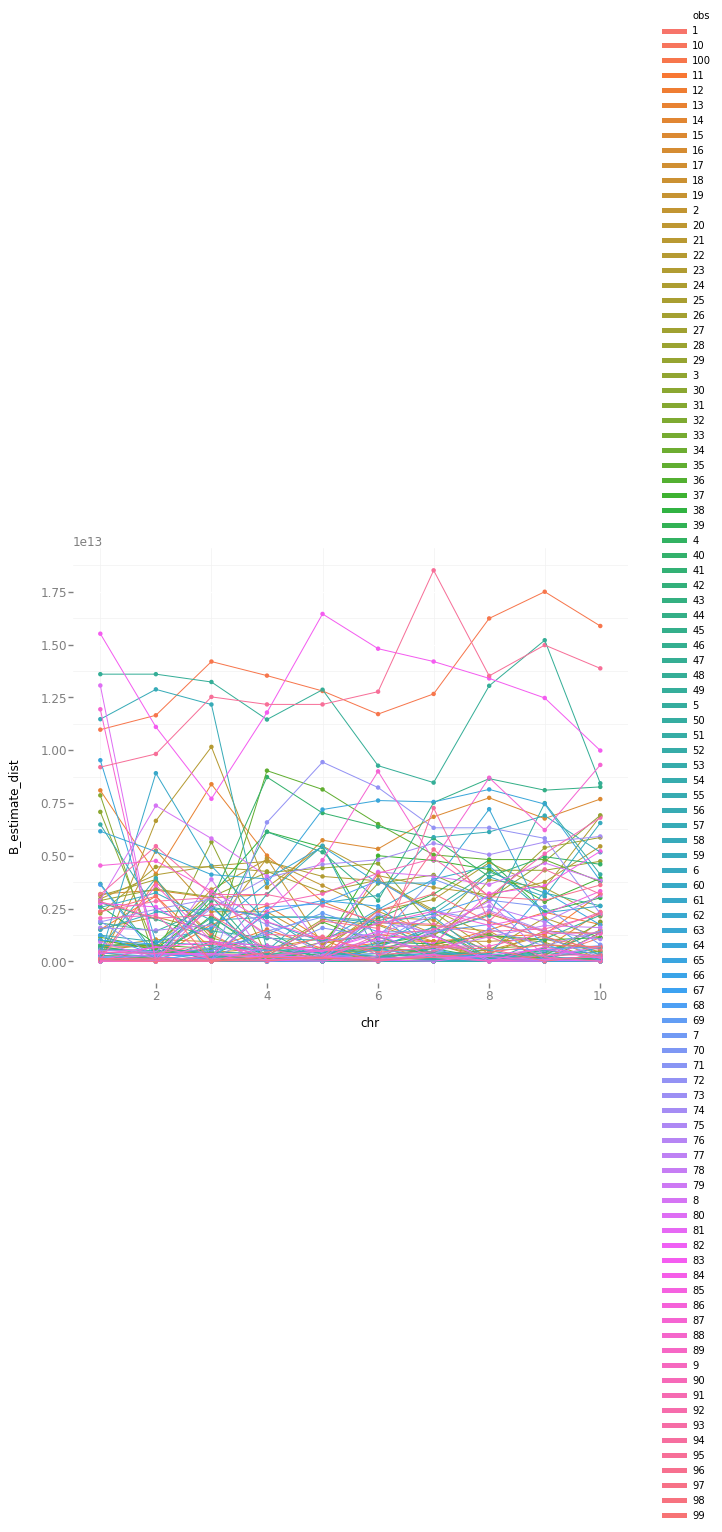

<ggplot: (-9223363252362515491)>


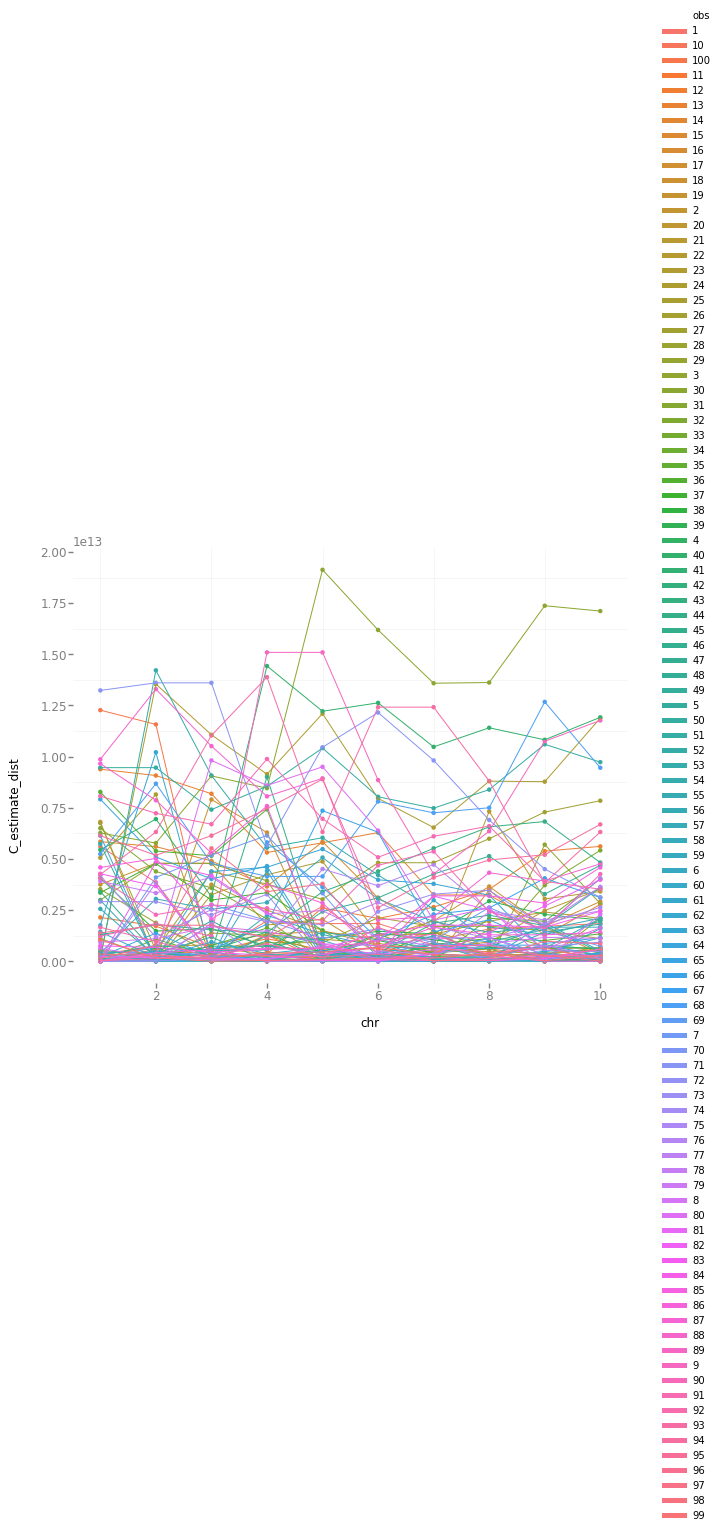

<ggplot: (8784492679295)>


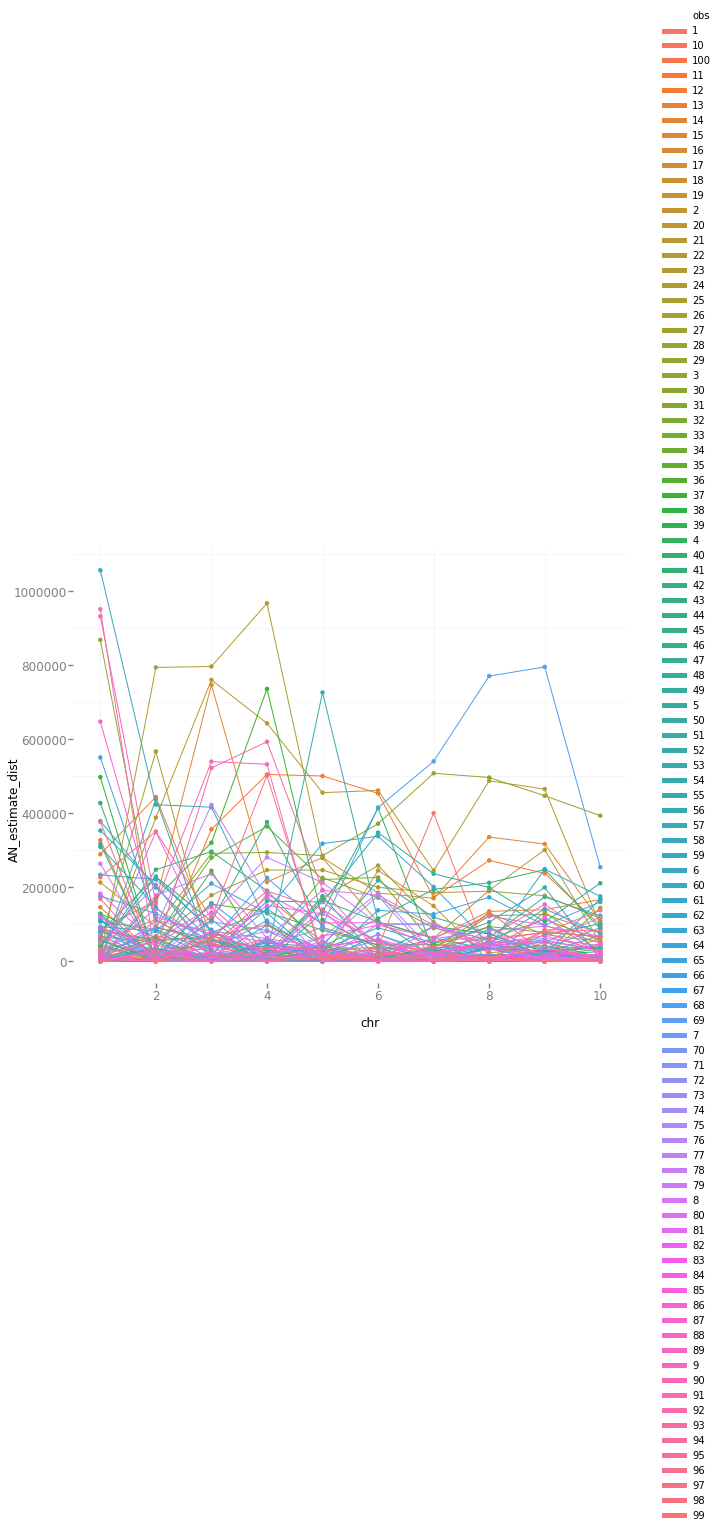

<ggplot: (8784493206718)>


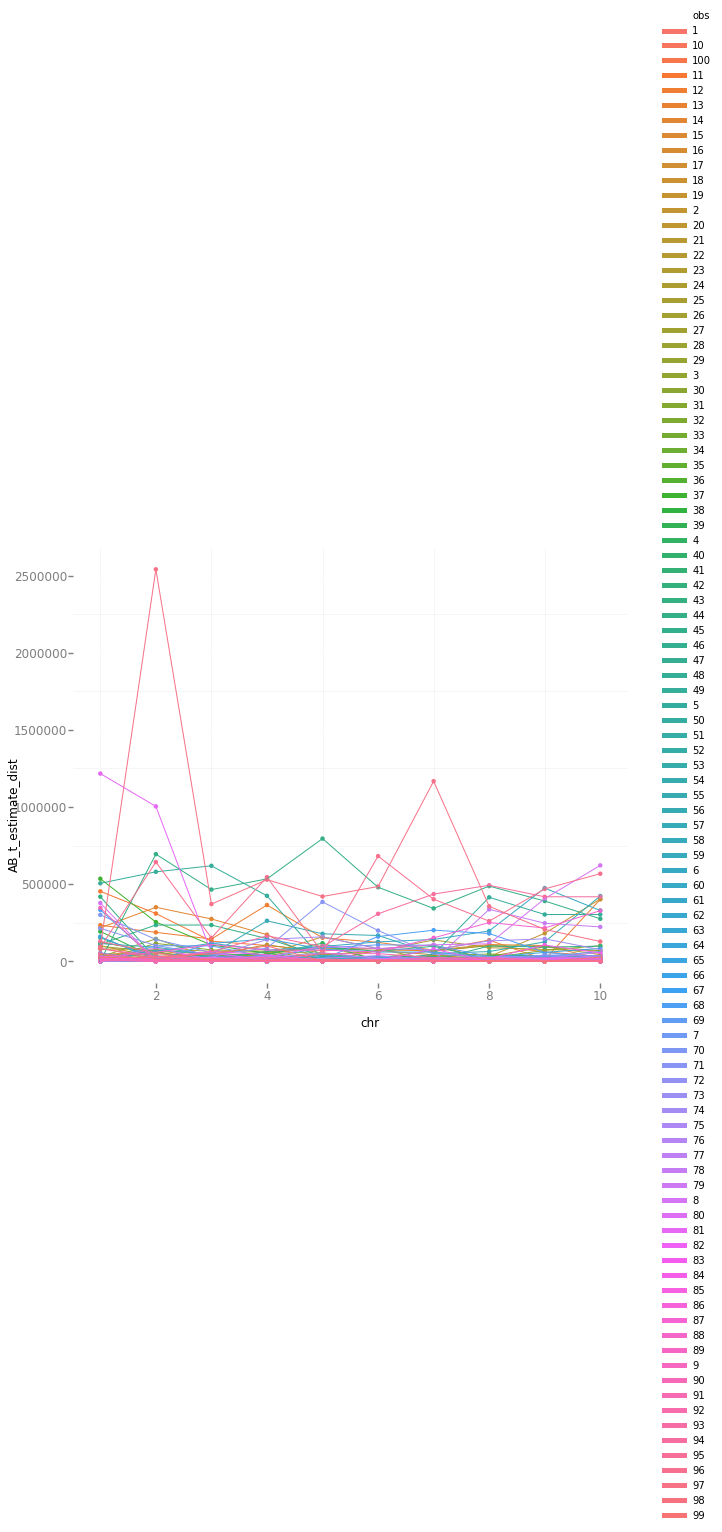

<ggplot: (8784492332671)>


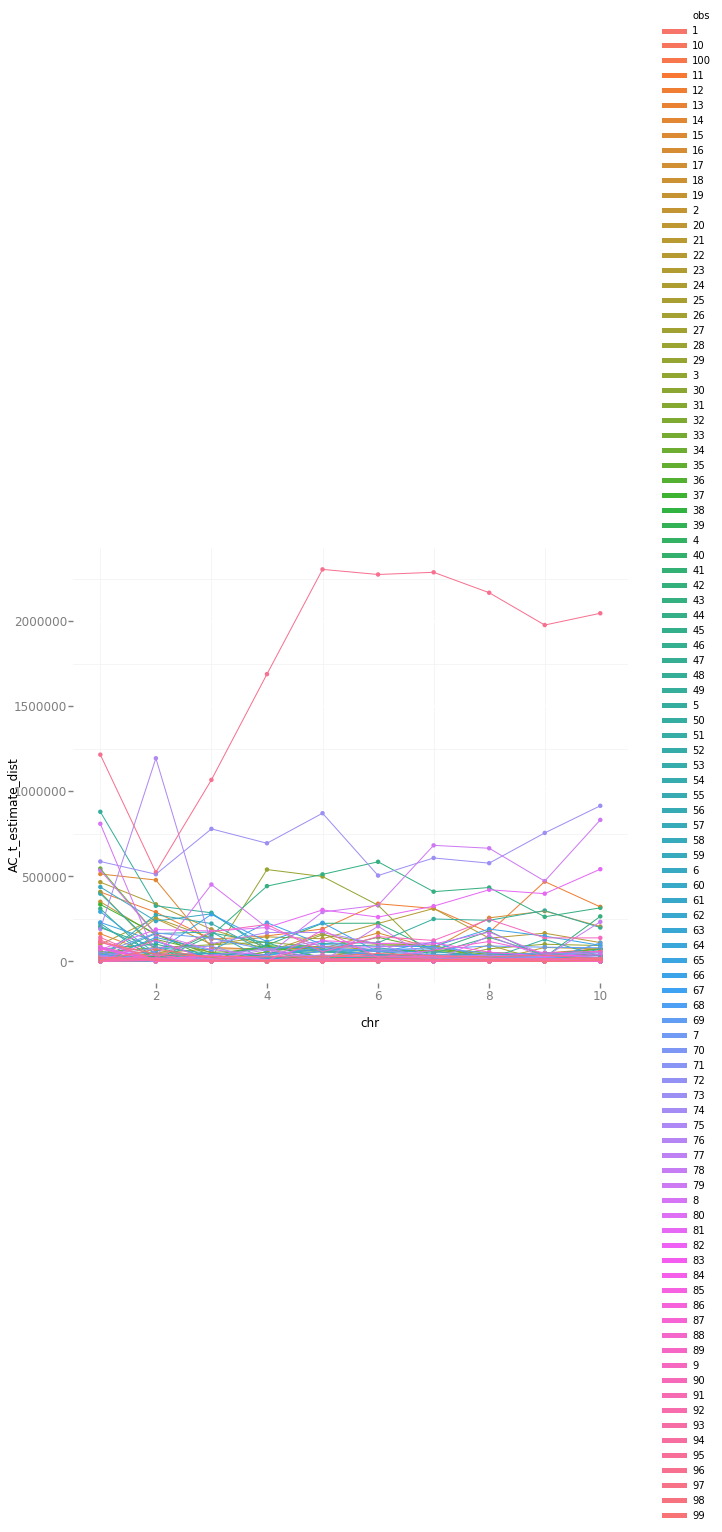

<ggplot: (-9223363252366899161)>


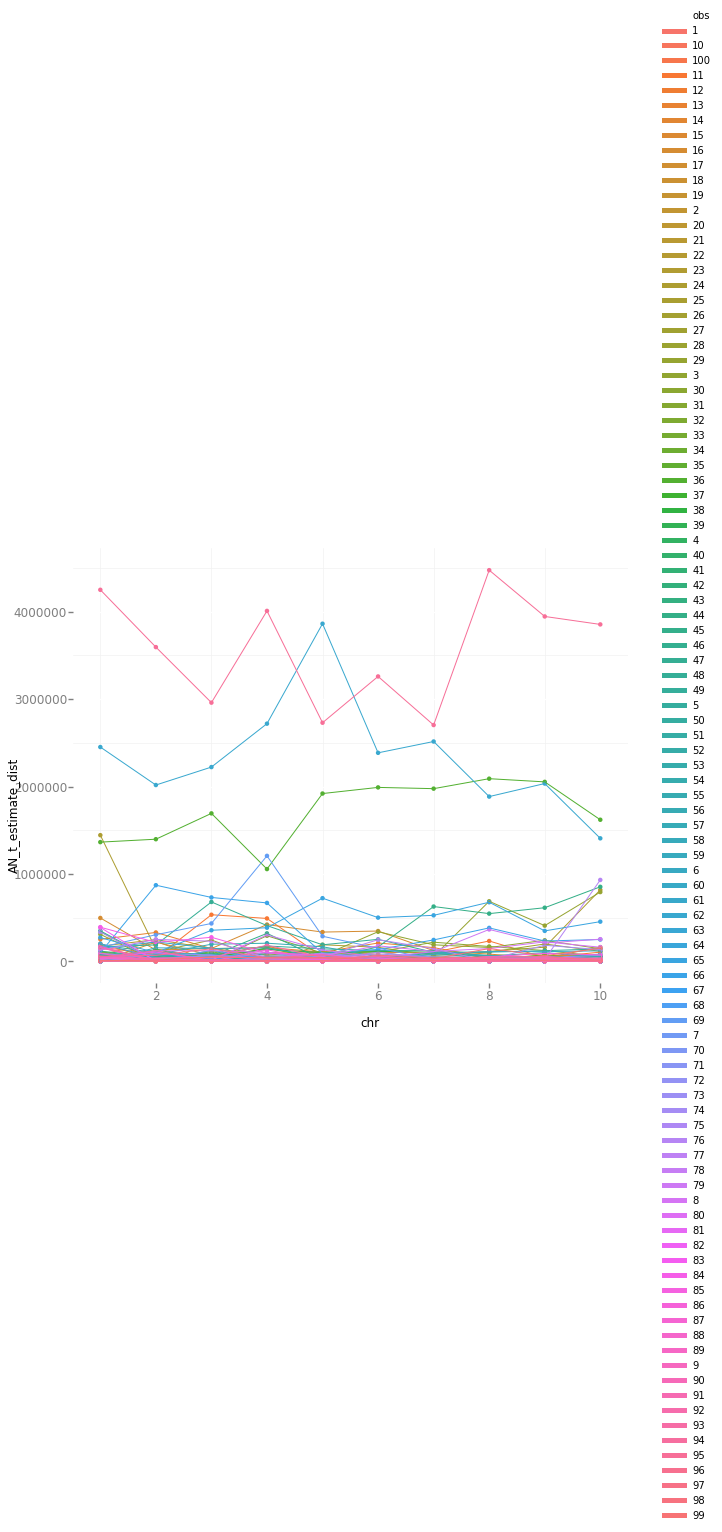

<ggplot: (8784546486897)>


In [53]:
for param in parameters:
    estimate_dist_name = '{}_estimate_dist'.format(param)
    plot = lineplot_estimate_dist(param, combined_PosteriorCharacteristics_observed_df, estimate_dist_name)    
    print(plot)

### Box plot of the squared difference of the HPDI_95 from the observed value for each chromosome
$(T-HL)^2 + (T-HH)^2$, if $T > HH$ or $T < HL$, then $((T-HL)^2 + (T-HH)^2)(-1)$

Ideally, each successive chromosome should reduce the squared difference from the observed value, down to 0. 

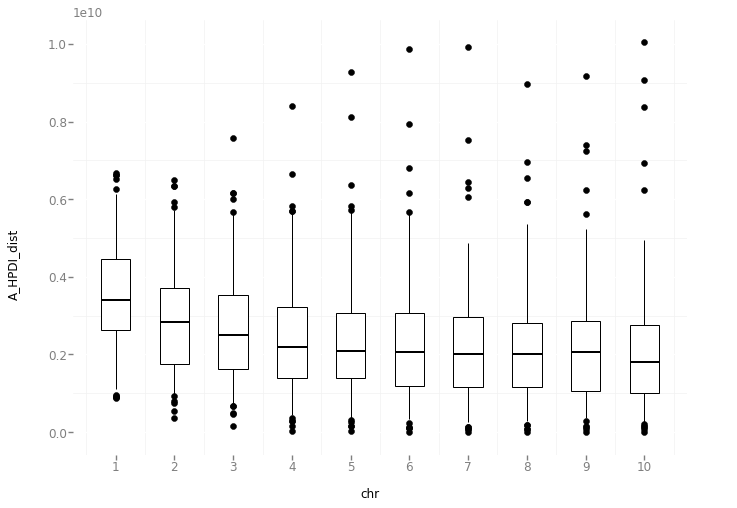

<ggplot: (-9223363252362326261)>


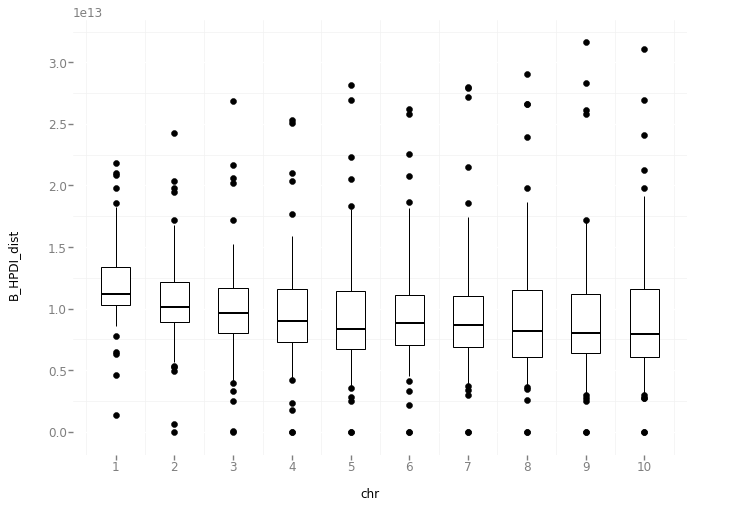

<ggplot: (8784492486057)>


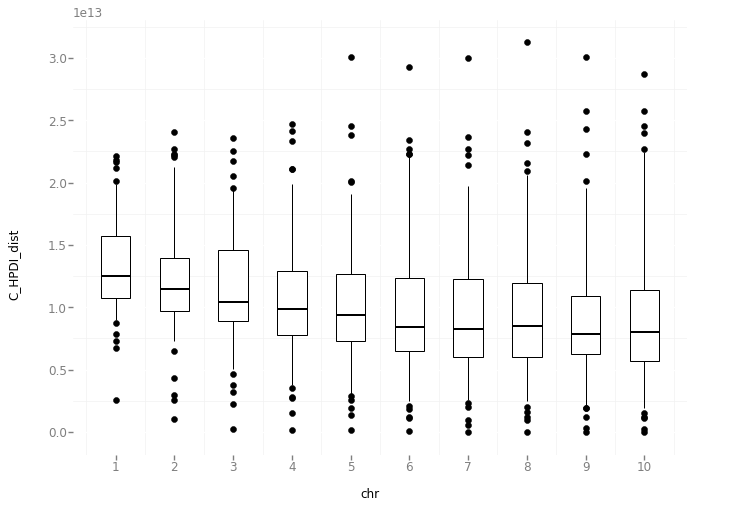

<ggplot: (-9223363252362350094)>


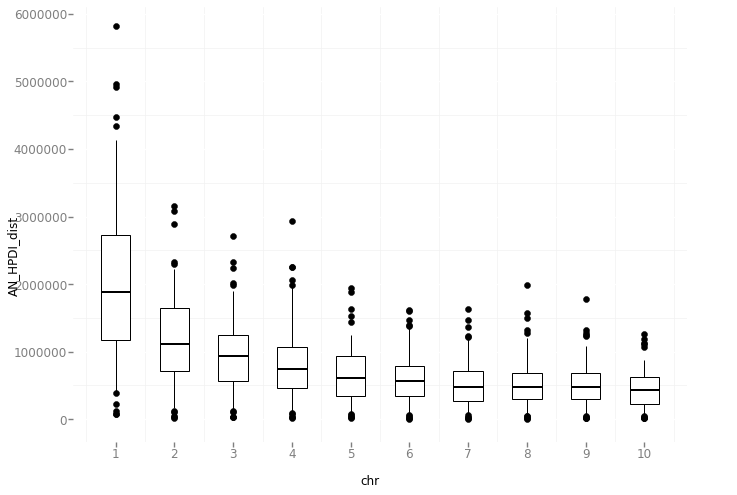

<ggplot: (8784492587016)>


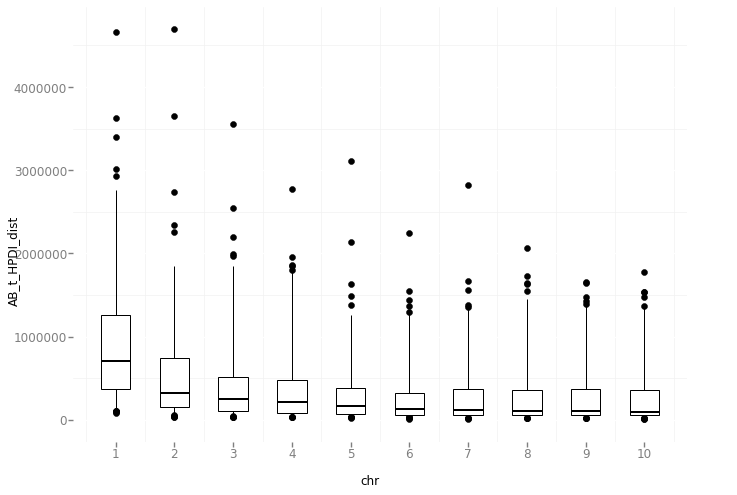

<ggplot: (-9223363252362488474)>


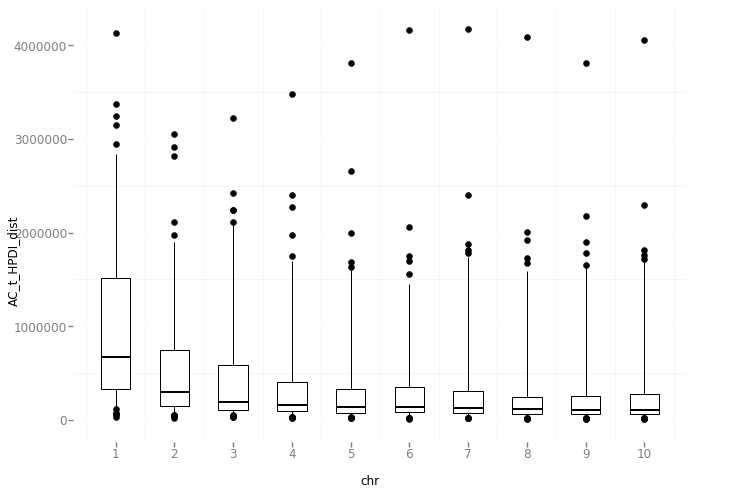

<ggplot: (8784493237999)>


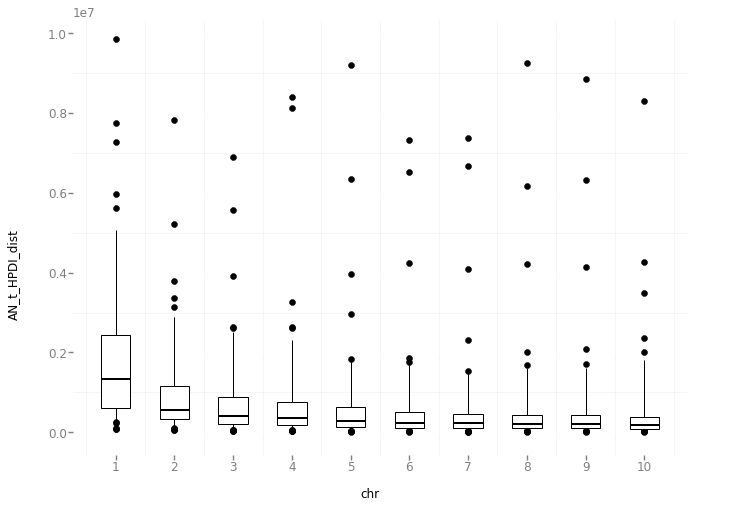

<ggplot: (-9223363252362219120)>


In [54]:
for param in parameters:
    combined_PosteriorCharacteristics_observed_df = calc_HPDI_dist(param, combined_PosteriorCharacteristics_observed_df)
    HPDI_dist_name = '{}_HPDI_dist'.format(param)
    plot = boxplot_estimate_dist(param, combined_PosteriorCharacteristics_observed_df, HPDI_dist_name)
    print(plot)

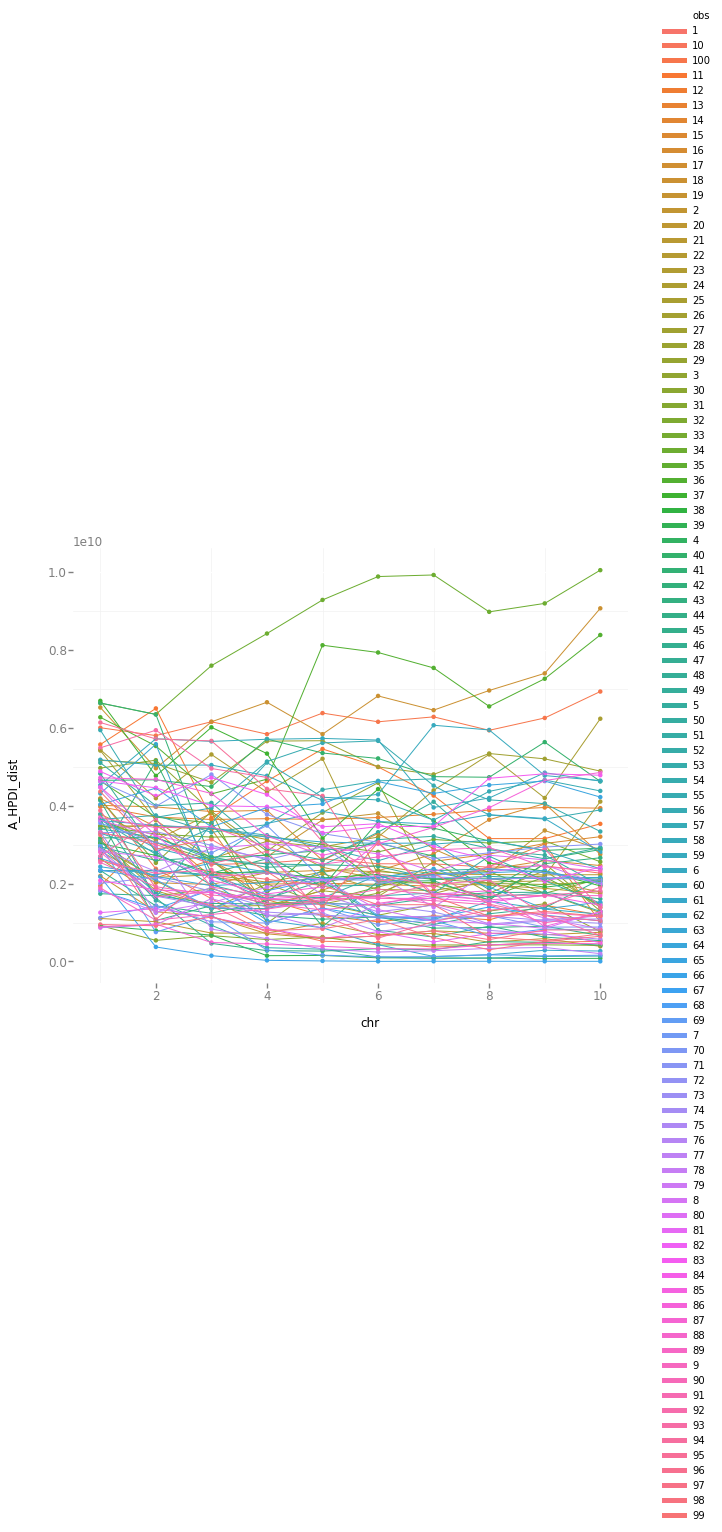

<ggplot: (8784488059912)>


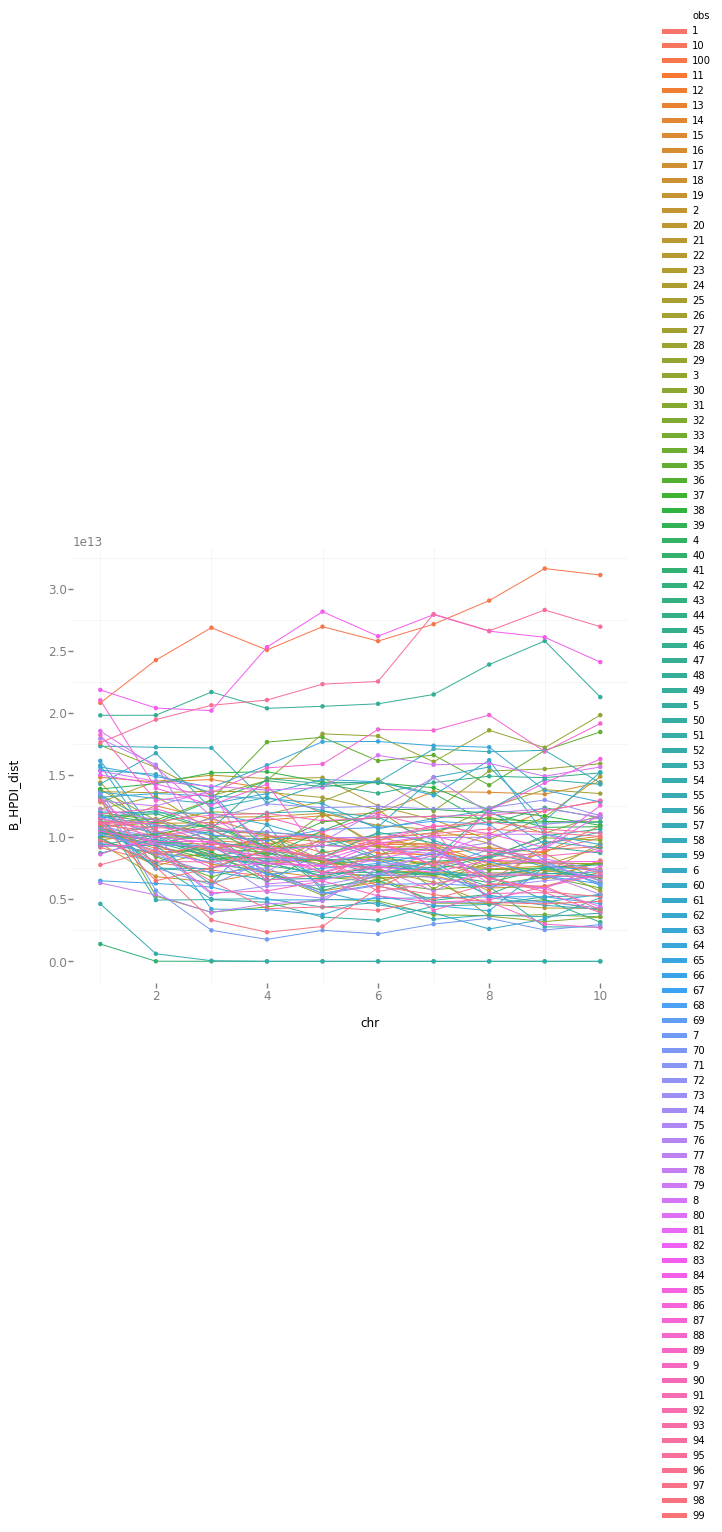

<ggplot: (-9223363252362315495)>


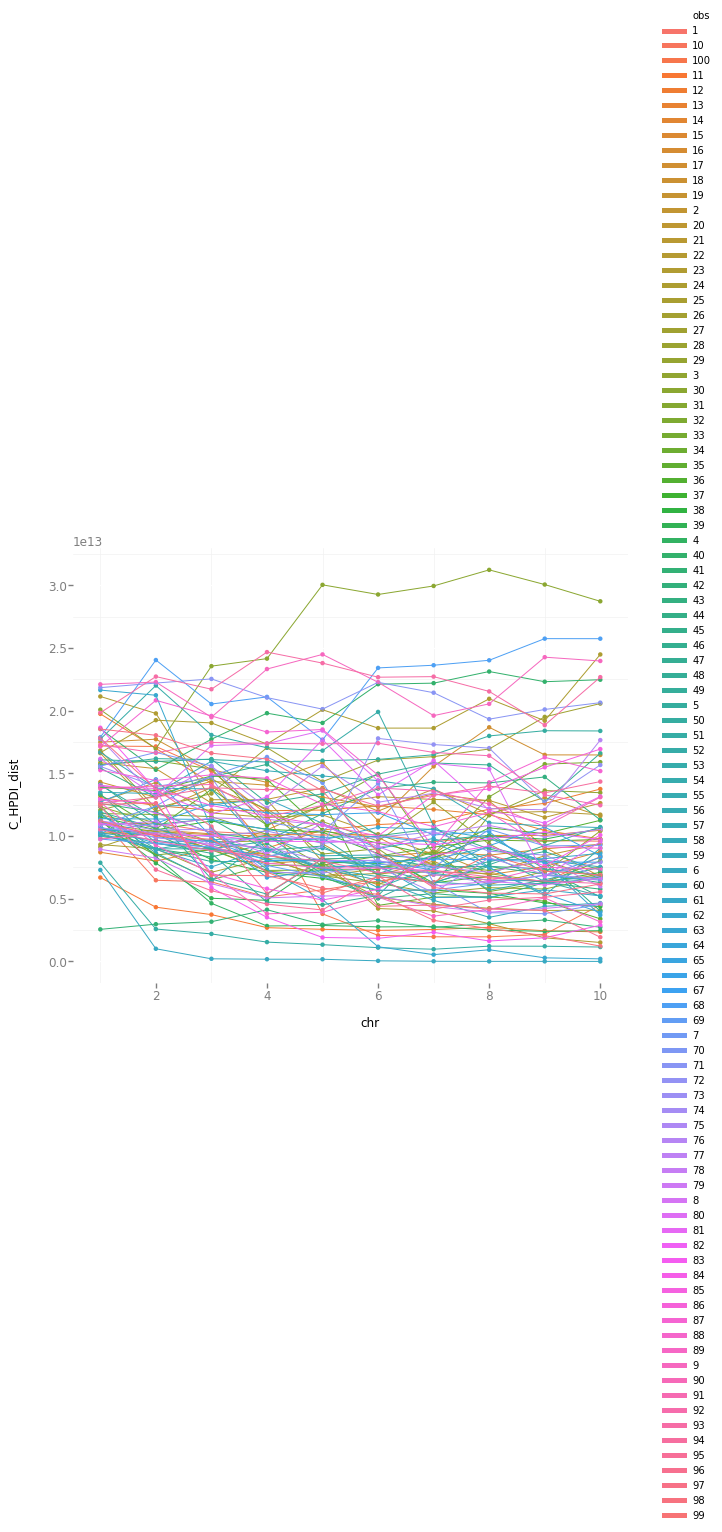

<ggplot: (-9223363252362481099)>


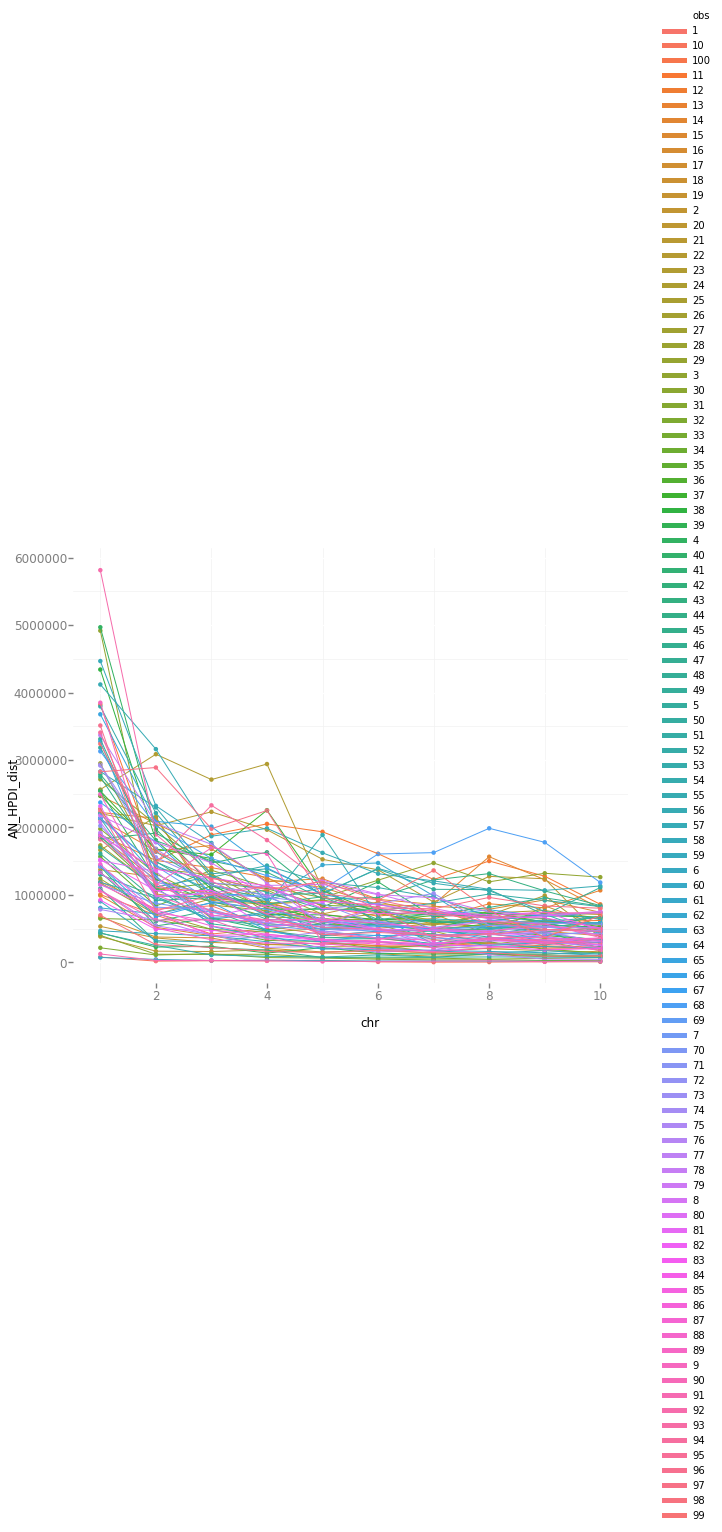

<ggplot: (8784492568924)>


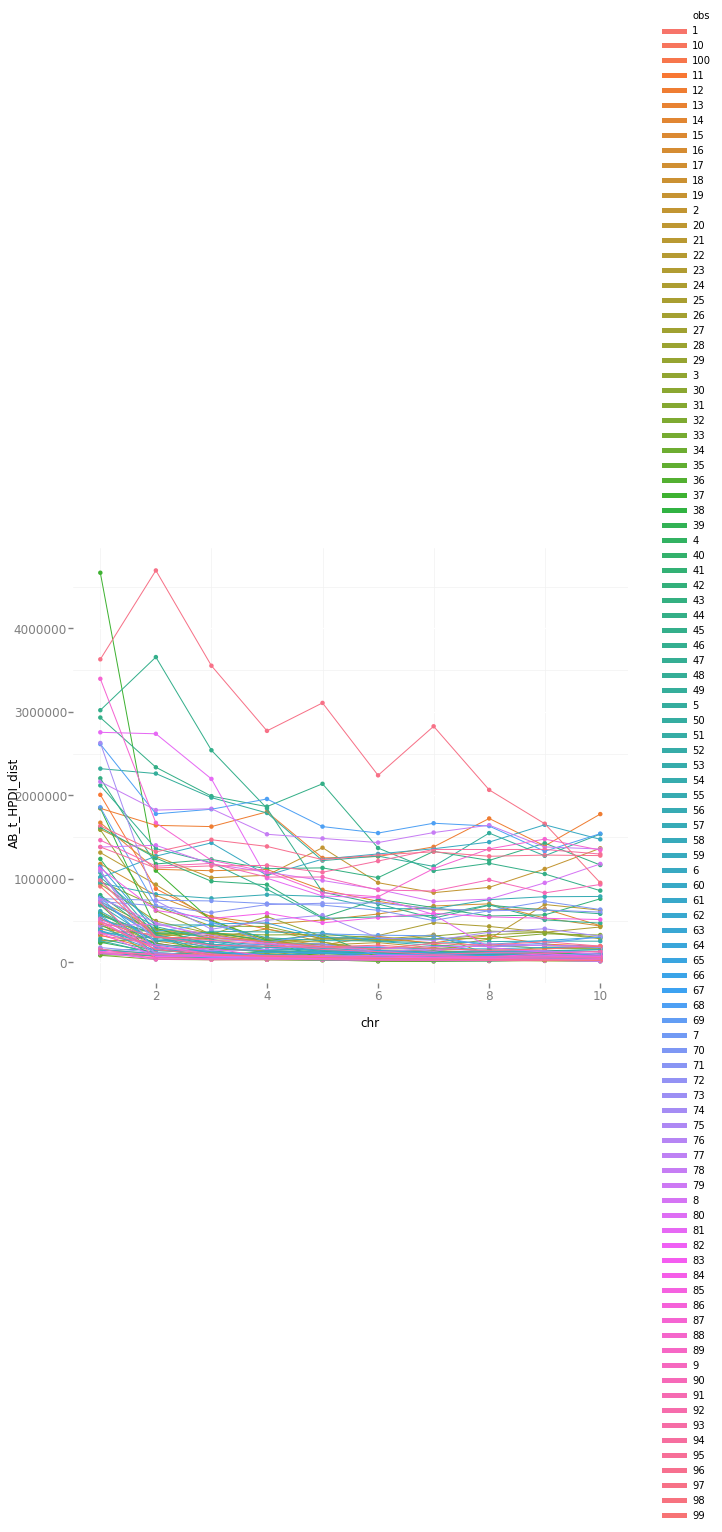

<ggplot: (-9223363252361694534)>


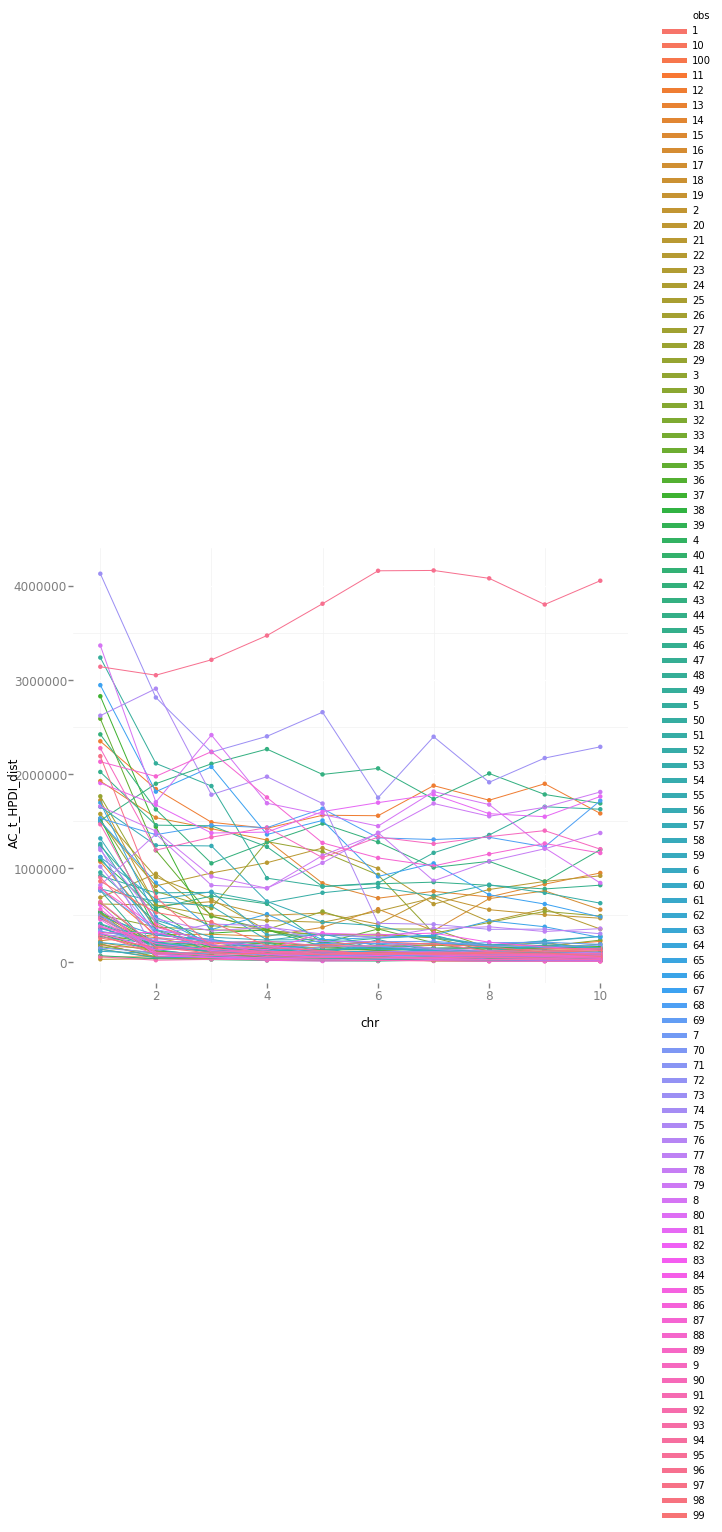

<ggplot: (8784493217782)>


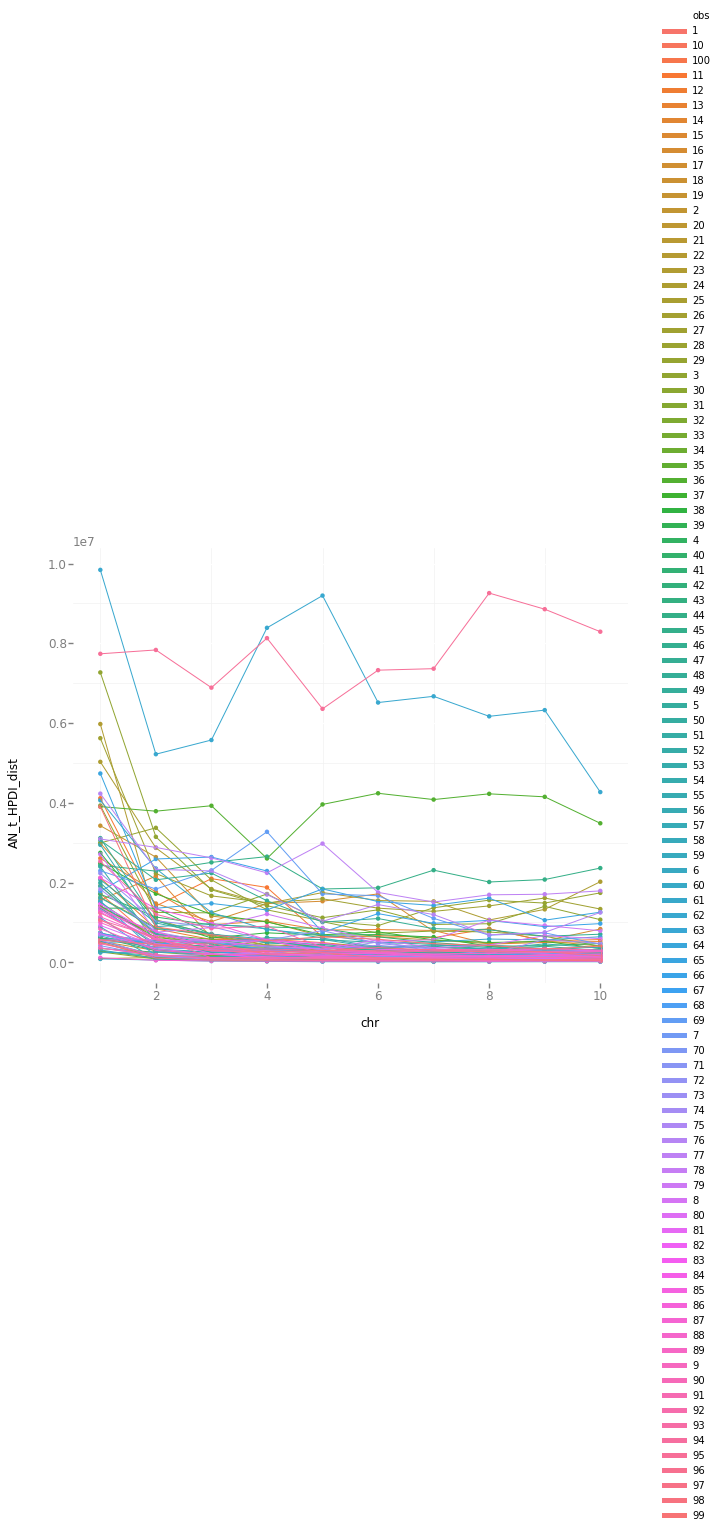

<ggplot: (8784493032645)>


In [55]:
for param in parameters:
    HPDI_dist_name = '{}_HPDI_dist'.format(param)
    plot = lineplot_estimate_dist(param, combined_PosteriorCharacteristics_observed_df, HPDI_dist_name)    
    print(plot)